## 1) Imports
- Load core libraries
- Connect to DuckDB

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
 
con = duckdb.connect("../data/processed/nba.duckdb")

## 2) Load & Filter Career Metrics

-Select career‐level WS/48 delta view and filter out players with
 fewer than **1,000 regular-season minutes** and **500 playoff minutes**
 to ensure stable per-48 metrics.

In [2]:
df = con.sql("""
SELECT *
FROM v_player_career
WHERE reg_mp >= 1000
  AND po_mp  >=  500
""").df()

con.close()   

In [3]:
print("Total players:", len(df))

Total players: 500


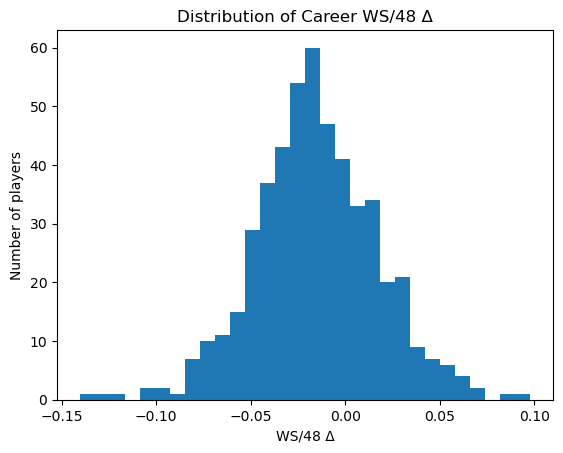

In [4]:
plt.hist(df["ws48_diff"], bins=30)
plt.title("Distribution of Career WS/48 Δ")
plt.xlabel("WS/48 Δ")
plt.ylabel("Number of players")
plt.show()

In [5]:
p5, p95 = df["ws48_diff"].quantile([0.05, 0.95])
print("5th percentile:", p5, " 95th percentile:", p95)


5th percentile: -0.06853946372694297  95th percentile: 0.03602515131121321


## 3) Create view with second metric Box Plus/Minus (BPM) Difference 
- BPM: An estimate of a player’s contribution to team point differential per 100 possessions, relative to league average.
- Sum player's playoff total BPM and subtract sum of player's regular BPM total
- Second metric provides more robustness to player analysis


In [9]:
import duckdb

con = duckdb.connect("../data/processed/nba.duckdb")

con.sql("""
CREATE OR REPLACE VIEW v_player_career_dual AS
WITH
  reg AS (
    SELECT Player,
           SUM(WS)  AS reg_ws,
           SUM(MP)  AS reg_mp,
           SUM(BPM) AS reg_bpm
    FROM adv_regular
    GROUP BY Player
  ),
  po AS (
    SELECT Player,
           SUM(WS)  AS po_ws,
           SUM(MP)  AS po_mp,
           SUM(BPM) AS po_bpm
    FROM adv_playoffs
    GROUP BY Player
  )
SELECT
  r.Player,
  reg_mp,
  po_mp,
  (po_ws  / NULLIF(po_mp,0))*48  AS po_ws48,
  (reg_ws / NULLIF(reg_mp,0))*48 AS reg_ws48,
  (po_ws  / NULLIF(po_mp,0))*48 - (reg_ws  / NULLIF(reg_mp,0))*48 AS ws48_diff,
  (po_bpm - reg_bpm)                                  AS bpm_diff
FROM reg r
JOIN po USING(Player);
""")

print(" View created -> v_player_career_dual")
con.close()


 View created -> v_player_career_dual


## 4) Preview Top and Bottom Performers

In [10]:
import duckdb
import pandas as pd

con = duckdb.connect("../data/processed/nba.duckdb")

# Apply the same sample‐size filter
df_both = con.sql("""
SELECT *
FROM v_player_career_dual
WHERE reg_mp >= 1000
  AND po_mp  >=  500
""").df()

con.close()

print(f"Players in analysis: {len(df_both)}")
df_both.head()


Players in analysis: 500


,Player,reg_mp,po_mp,po_ws48,reg_ws48,ws48_diff,bpm_diff
0,Travis Best,11672.0,708.0,0.108475,0.099109,0.009366,8.1
1,P.J. Brown,19900.0,2042.0,0.119882,0.133869,-0.013987,2.9
2,Marcus Camby,27506.0,1736.0,0.069124,0.146412,-0.077287,-34.9
3,Sam Cassell,21881.0,2242.0,0.094202,0.144344,-0.050143,-14.6
4,Derrick Coleman,7745.0,897.0,0.144482,0.116514,0.027968,19.4


### Scatter Plot: WS/48 Δ vs BPM Δ

A positive correlation would confirm both metrics point to the same risers/fallers.

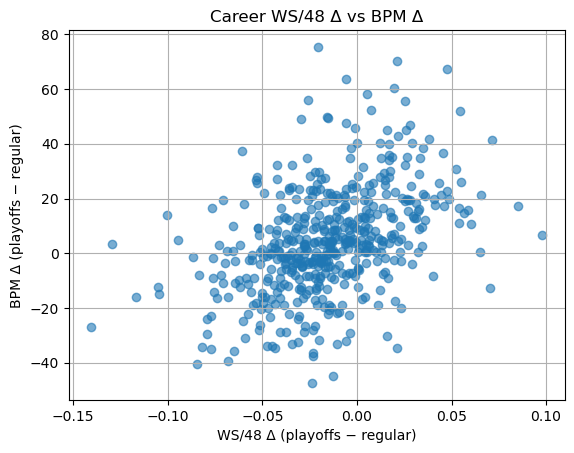

In [11]:
import matplotlib.pyplot as plt

plt.scatter(df_both["ws48_diff"], df_both["bpm_diff"], alpha=0.6)
plt.title("Career WS/48 Δ vs BPM Δ")
plt.xlabel("WS/48 Δ (playoffs − regular)")
plt.ylabel("BPM Δ (playoffs − regular)")
plt.grid(True)
plt.show()


### Correlation between metrics

Compute the Pearson correlation coefficient to quantify the relationship.


In [12]:
corr = df_both[["ws48_diff","bpm_diff"]].corr().iloc[0,1]
print(f"Pearson correlation WS/48 Δ vs BPM Δ: {corr:.3f}")


Pearson correlation WS/48 Δ vs BPM Δ: 0.423
